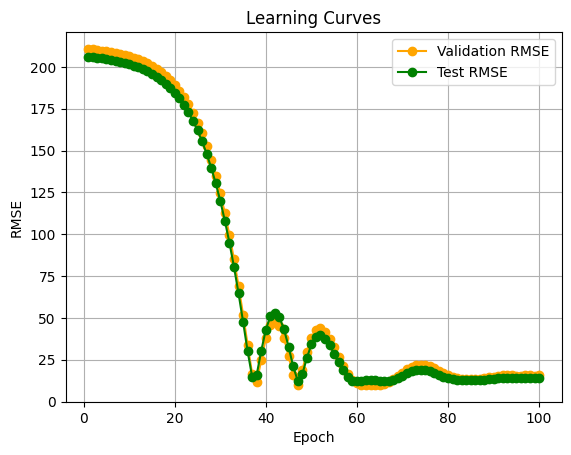

In [4]:
from data import load_data, data_prep
from train import train, plot_learning_curve
from data_openml import DataSetCatCon
from torch.utils.data import DataLoader
from models import SAINT
import torch.optim as optim
from sklearn.feature_selection import SelectFromModel
from catboost import CatBoostClassifier
import pandas as pd


X1, y = load_data(1000, 500)

# select best fingerprints 
fgpts = X1.iloc[:, 2:-1]
model2 = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=0)
model2.fit(fgpts, y)
fgpts_selector = SelectFromModel(model2, prefit=True, threshold="mean", max_features=100)
X = pd.concat([X1.iloc[:, :2], X1.loc[:, fgpts.columns[fgpts_selector.get_support()]]], axis=1)

# max_features en data_prep para que ¿?¿?¿?¿?¿?¿?

cat_dims, cat_idxs, con_idxs, X_train, y_train, X_valid, y_valid, X_test, y_test, train_mean, train_std, continuous_mean_std = data_prep(X, y, datasplit=[.65, .15, .2])

train_ds = DataSetCatCon(X_train, y_train, cat_idxs,'reg',continuous_mean_std)
trainloader = DataLoader(train_ds, batch_size=256, shuffle=True,num_workers=4)

valid_ds = DataSetCatCon(X_valid, y_valid, cat_idxs,'reg', continuous_mean_std)
validloader = DataLoader(valid_ds, batch_size=256, shuffle=False,num_workers=4)

test_ds = DataSetCatCon(X_test, y_test, cat_idxs,'reg', continuous_mean_std)
testloader = DataLoader(test_ds, batch_size=256, shuffle=False,num_workers=4)

model = SAINT(
    categories = tuple(cat_dims), 
    num_continuous = len(con_idxs),                
    dim = 32, # default                         
    dim_out = 1,                       
    depth = 1,                        
    heads = 4,                         
    attn_dropout = 0.8,             
    ff_dropout = 0.8,                  
    mlp_hidden_mults = (4, 2),       
    cont_embeddings = 'MLP', # default 
    attentiontype = 'colrow', # default 
    final_mlp_style = 'sep', # default
    y_dim = 1 # porque es regression 
)

optimizer = optim.AdamW(model.parameters(),lr=0.0001)
scheduler = 'cosine' # default 
epochs = 100

valid_rmse, test_rmse = train(model, optimizer, scheduler, epochs, trainloader, validloader, testloader)

plot_learning_curve(valid_rmse, test_rmse)
